In [28]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import shap
import socket
import matplotlib.pyplot as plt
from tqdm import tqdm

In [29]:
df = pd.read_csv("../data/raw/wustl_hdrl_2024.csv")

C:\Users\ABHINAV\AppData\Local\Temp\ipykernel_2068\4219559405.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/raw/wustl_hdrl_2024.csv")


In [30]:
df.head()

,Dir,Flgs,SrcAddr,DstAddr,Sport,Dport,SrcBytes,DstBytes,SrcLoad,DstLoad,...,sswap_sin,sswap_sout,sdiskusage_total,sdiskusage_used,sdiskusage_free,sdiskusage_percent,Boot_Time_with_date,DTime,Attack_categories,Label
0,->,e,192.168.3.2,192.168.2.2,36390,4022,1651.0,272.0,10440.0,1612.000,...,0,0,502392610816,51814645760,424982593536,10,2023-12-23 15:38:11,104.316401,normal,0
1,->,e,192.168.3.2,192.168.2.2,49608,4022,1673.0,272.0,10576.0,1611.000,...,0,0,502392610816,51814674432,424982564864,10,2023-12-23 15:38:11,104.207156,normal,0
2,->,e,192.168.3.2,192.168.2.2,34596,4022,1650.0,272.0,10364.0,1602.000,...,0,0,502392610816,51814686720,424982552576,10,2023-12-23 15:38:11,104.177347,normal,0
3,->,e d,78.151.208.250,192.168.2.2,18346,4022,1450.0,174.0,0.0,306.469,...,0,0,502392610858,50459127848,426338111537,15,2023-05-09 15:19:38,25.821966,DDoS,1
4,->,e d,143.109.155.233,192.168.2.2,18346,4022,1452.0,174.0,0.0,305.268,...,0,0,502392610863,50459127854,426338111539,15,2023-05-09 15:19:38,25.945508,DDoS,1


In [31]:
non_gen = ["SrcAddr","DstAddr","SrcMac","DstMac","IMEI","Boot_Time_with_date"]

In [32]:
df = df.drop(columns=non_gen)

In [33]:
df

,Dir,Flgs,Sport,Dport,SrcBytes,DstBytes,SrcLoad,DstLoad,SrcGap,DstGap,...,sswap_percent,sswap_sin,sswap_sout,sdiskusage_total,sdiskusage_used,sdiskusage_free,sdiskusage_percent,DTime,Attack_categories,Label
0,->,e,36390,4022,1651.0,272.0,10440.0,1612.000,0.0,0.0,...,0,0,0,502392610816,51814645760,424982593536,10,104.316401,normal,0
1,->,e,49608,4022,1673.0,272.0,10576.0,1611.000,0.0,0.0,...,0,0,0,502392610816,51814674432,424982564864,10,104.207156,normal,0
2,->,e,34596,4022,1650.0,272.0,10364.0,1602.000,0.0,0.0,...,0,0,0,502392610816,51814686720,424982552576,10,104.177347,normal,0
3,->,e d,18346,4022,1450.0,174.0,0.0,306.469,0.0,0.0,...,0,0,0,502392610858,50459127848,426338111537,15,25.821966,DDoS,1
4,->,e d,18346,4022,1452.0,174.0,0.0,305.268,0.0,0.0,...,0,0,0,502392610863,50459127854,426338111539,15,25.945508,DDoS,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145118,->,e d,3617,4022,1453.0,174.0,0.0,307.200,0.0,0.0,...,0,0,0,502392611534,50459128438,426338112161,80,10.176143,DDoS,1
145119,->,e d,3617,4022,1452.0,174.0,0.0,306.281,0.0,0.0,...,0,0,0,502392611536,50459128445,426338112166,80,10.152515,DDoS,1
145120,->,e d,3617,4022,1450.0,174.0,0.0,306.492,0.0,0.0,...,0,0,0,502392611545,50459128446,426338112174,81,10.068303,DDoS,1
145121,->,e,57484,4022,1648.0,272.0,10397.0,1608.000,0.0,0.0,...,0,0,0,30612852736,19991822336,9289617408,68,28.217784,normal,0


In [34]:
encoders = {}

for col in ["Dir","Flgs","Attack_categories","Label"]:
    if col in df.columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        encoders[col] = le 

In [35]:
X = df.drop(columns=["Attack_categories", "Label"])   # Label is attack vs benign
y_att = df["Attack_categories"] 
y_bin = df["Label"]  # Binary label: 0 for benign, 1 for attack

In [36]:
y_att.unique()

array([4, 1, 0, 2, 3])

In [37]:
print(dict(zip(encoders["Attack_categories"].classes_, range(len(encoders["Attack_categories"].classes_)))))

{'Buffer_overflow': 0, 'DDoS': 1, 'MiTM': 2, 'Ransomware': 3, 'normal': 4}


In [38]:
print("Attack Categories distribution:")
print(df["Attack_categories"].value_counts())

print("\nBinary Label distribution:")
print(df["Label"].value_counts())

Attack Categories distribution:
Attack_categories
4    132884
1      9971
2      1672
3       528
0        68
Name: count, dtype: int64

Binary Label distribution:
Label
0    132884
1     12239
Name: count, dtype: int64


In [39]:
drop_cols = ["SrcAddr","DstAddr","SrcMac","DstMac","IMEI","RTime","Packet_num"]
X = X.drop(columns=[c for c in drop_cols if c in X.columns])

In [40]:
categorical = ["Dir", "Flgs"]
numeric = [col for col in X.columns if col not in categorical + drop_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical),
        ("num", StandardScaler(), numeric)
    ]
)

In [41]:
def service_to_port(x):
    try:
        return int(x) if str(x).isdigit() else socket.getservbyname(x)
    except:
        return -1   # unknown service

X["Sport"] = X["Sport"].apply(service_to_port)
X["Dport"] = X["Dport"].apply(service_to_port)

# Attack or Normal Binary Detection:

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=0.2, random_state=42, stratify=y_bin)

In [43]:
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)

In [44]:
class_weights_ = dict(zip(classes, class_weights))
class_weights

array([0.54605059, 5.92881217])

In [45]:
rf = RandomForestClassifier(
    n_estimators=200,
    class_weight=class_weights_,
    random_state=42,
    n_jobs=-1
)

pipeline = Pipeline(steps=[("preprocess", preprocess), ("clf", rf)])
pipeline.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [46]:
cat_cols = ["Dir", "Flgs"]   # adjust based on your df
num_cols = [col for col in X.columns if col not in cat_cols]

# Preprocessor: OHE for categoricals, scale numerics
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)

# Full pipeline
rf = RandomForestClassifier(
    n_estimators=200,
    class_weight="balanced",
    random_state=42,
    n_jobs=4
)

pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", rf)
])

# Fit on training
pipeline.fit(X_train, y_train)

# Predict on test
y_pred = pipeline.predict(X_test)

In [47]:
print("\nClassification Report (Binary IDS):\n")
print(classification_report(y_test, y_pred, digits=4))

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Classification Report (Binary IDS):

              precision    recall  f1-score   support

           0     0.9993    0.9996    0.9994     26577
           1     0.9955    0.9922    0.9939      2448

    accuracy                         0.9990     29025
   macro avg     0.9974    0.9959    0.9966     29025
weighted avg     0.9990    0.9990    0.9990     29025


Confusion Matrix:
 [[26566    11]
 [   19  2429]]


In [48]:
X_test.shape

(29025, 67)

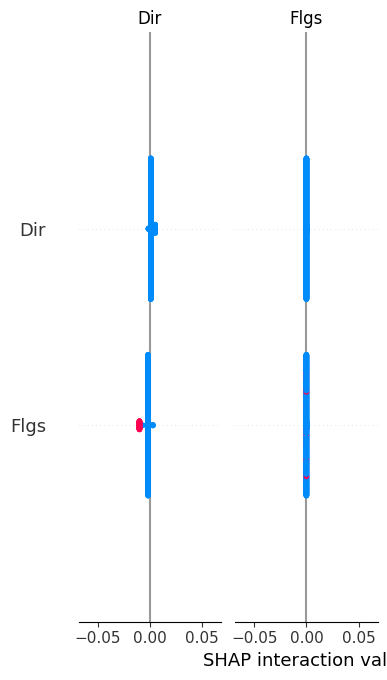

In [49]:
X_sample = X_test.sample(1000, random_state=42)

# Use TreeExplainer safely
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_sample)

# Summary plot
shap.summary_plot(shap_values, X_sample, plot_type="bar")

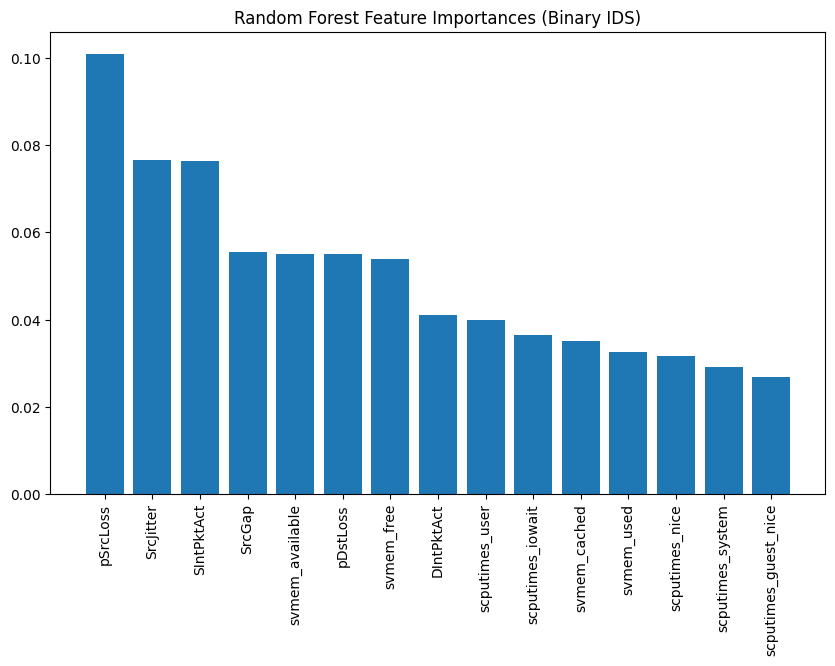

                 Feature  Importance
27              pSrcLoss    0.100960
14             SrcJitter    0.076633
12            SIntPktAct    0.076407
8                 SrcGap    0.055448
45       svmem_available    0.055148
28              pDstLoss    0.054939
48            svmem_free    0.054010
13            DIntPktAct    0.041142
30        scputimes_user    0.039922
34      scputimes_iowait    0.036445
52          svmem_cached    0.035106
47            svmem_used    0.032541
31        scputimes_nice    0.031604
32      scputimes_system    0.029116
39  scputimes_guest_nice    0.026823


In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Feature importance
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Top 15 features for plotting
top_n = 15
plt.figure(figsize=(10,6))
plt.title("Random Forest Feature Importances (Binary IDS)")
plt.bar(range(top_n), importances[indices[:top_n]], align='center')

# Handle column name mismatch
feature_names = X_train.columns
if len(importances) > len(feature_names):
    # If importances come from transformed features, just use indices for top_n
    try:
        plt.xticks(range(top_n), feature_names[indices[:top_n]], rotation=90)
    except IndexError:
        plt.xticks(range(top_n), [f"Feature {i}" for i in indices[:top_n]], rotation=90)
else:
    plt.xticks(range(top_n), feature_names[indices[:top_n]], rotation=90)

plt.show()

# Top features DataFrame (safe)
min_len = min(len(feature_names), len(importances))
feat_imp = pd.DataFrame({
    "Feature": feature_names[:min_len],
    "Importance": importances[:min_len]
}).sort_values("Importance", ascending=False)

print(feat_imp.head(top_n))
